In [1]:
import math
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys

try:
    from tqdm.notebook import tqdm
except Exception:
    print('For a nice progress bar install tqdm (pip3 install tqdm)', file=sys.stderr)
    def tqdm(iterable, *args, **kwargs):
        return iterable

    
def progress_wrapper(iterable, level, max_progress_level):
    if level == 0:
        return tqdm(iterable)
    elif level <= max_progress_level:  # configurable
        return tqdm(iterable, leave=False)
    else:
        return iterable
    

def compute_loss(time_points, predicted_metrics, true_metrics):
    loss_sum = 0.0
    # Iterace through infected, recovered and dead
    for predicted, true in zip(predicted_metrics, true_metrics):
        assert predicted.shape[0] == true.shape[0], \
        "expected solution's size to be {}, but got {}".format(true.shape[0], predicted.shape[0])
        loss_sum += np.mean((true - predicted) ** 2)
    return loss_sum


def cut_metrics(metrics, from_idx, to_idx):
    if to_idx is None:
        return [x[from_idx:] for x in metrics]
    else:
        return [x[from_idx:to_idx] for x in metrics]


def fit(ode_system_getter, time_points, params, to_metrics, true_metrics, max_progress_level=1, val_samples=0):
    """
    ode_system_getter: функция, которая получает набор параметров из params и возвращает tuple,
                       в котором первый элемент – функция, задающая систему уравнений
                       (и принимающая только параметры y и t)
                       и соответствующая аргументу func функции scipy.integrate.odeint,
                       а второй элемент – вектор начальных условий y0 функции scipy.integrate.odeint
    time_points: точки, для которых нужно решить систему уранений. Аналогично параметру t в scipy.integrate.odeint
    params: список, в котором каждый i-тый элемент –
            список возможных значений i-того параметра, передаваемого в ode_system_getter
    to_metrics: функция, принимающая solution (результат функции scipy.integrate.odeint)
                и отдающая список метрик, по которым будет производиться оценка параметров.
                каждая метрика – одномерный numpy-массив значений
    true_metrics: список метрик для данных, под которые мы подстраиваемся
                  каждая метрика – одномерный numpy-массив значений
    max_progress_level: глубина вложенных циклов, для которых будет отображаться progress-bar. Считается от 0.
    val_samples: количество элементов, отсекаемых на валидацию.
                 целое число означает количество элементов,
                 дробное в интервале (0;1) – долю от общего числа элементов
                  
    
    """
    
    val_len = math.ceil(len(time_points)*val_samples) if val_samples < 1 else val_samples
    train_len = len(time_points) - val_len
    assert train_len > 0, 'Too big value for val_samples, no train samples left'
    if val_len <= 0:
        print('Too small value for val_samples, no validation loss will be computed', file=sys.stderr)
    train_points = time_points[:train_len]
    val_points = time_points[train_len:]
    true_train = cut_metrics(true_metrics, 0, train_len)
    true_val = cut_metrics(true_metrics, train_len, None)
    
    def fit_stage(left_params, current_values, level):
        if left_params:
            best_train_loss = None
            best_val_loss = None
            best_solution = None
            best_params = None
            for param_value in progress_wrapper(left_params[-1], level, max_progress_level):
                new_values = current_values + (param_value,)
                return_value = fit_stage(left_params[:-1], new_values, level+1)
                if return_value is None:
                    continue
                train_loss, val_loss, solution, params_for_loss = return_value
                if best_train_loss is None or best_train_loss > train_loss:
                    best_train_loss = train_loss
                    best_val_loss = val_loss
                    best_solution = solution
                    best_params = params_for_loss
            return best_train_loss, best_val_loss, best_solution, best_params
        else:
            return_value = ode_system_getter(*list(reversed(current_values)))
            if return_value is None:  # e.g. invalid parameters
                return None
            ode_system, initial_conditions = return_value
            solution = odeint(ode_system, initial_conditions, time_points)
            train_loss = compute_loss(train_points, cut_metrics(to_metrics(solution), 0, train_len), true_train)
            if val_len > 0:
                val_loss = compute_loss(val_points, cut_metrics(to_metrics(solution), train_len, None), true_val)
            else:
                val_loss = 0.0
            return train_loss, val_loss, solution, current_values
    
    best_train_loss, val_loss, best_solution, best_params = fit_stage(params, tuple(), 0)
    return best_train_loss, val_loss, best_solution, tuple(reversed(best_params))

In [21]:
from matplotlib.backends.backend_pdf import PdfPages

# Небольшая функция для быстрой отрисовки графичков, объединяющая реальные данные и смоделированные
def plot_data_together(time_points, predicted_data, true_data, upper_limit, labels=None, \
                       filename='italy_pugachev_fix_30.pdf'):
    colors = ['b', 'g', 'r', 'y', 'k', 'm']
    if not labels:
        labels = ['']*len(true_data)
    susceptible, infected = true_data
    
    fig = plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    for y_pred, y_true, color, label in zip(predicted_data, true_data, colors, labels):
        plt.plot(time_points, y_true, color+'--', label=label+' (true)', alpha=0.7)
        plt.plot(time_points, y_pred, color, label=label+' (pred)')
        
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.legend()
    plt.ylim([0, upper_limit])

    #Same plot but on log scale
    plt.subplot(1,2,2)
    for y_pred, y_true, color, label in zip(predicted_data, true_data, colors, labels):
        plt.plot(time_points, y_true, color+'--', label=label+' (true)', alpha=0.7)
        plt.plot(time_points, y_pred, color, label=label+' (pred)')
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.legend()
    plt.ylim([1, upper_limit])
    
    pp = PdfPages(filename, keep_empty=False)
    pp.savefig(fig)
    pp.close()

In [22]:
p = np.arange(0.000,0.001,0.0002)[1:]
p = np.append(p, np.arange(0.000,0.01,0.002)[1:])
p = np.append(p, np.arange(0.00,0.1,0.02)[1:])
p = np.append(p, np.arange(0.0,1.1,0.2)[1:])
p = np.append(p, np.arange(0,6,1)[1:])
p, len(p)

(array([2.e-04, 4.e-04, 6.e-04, 8.e-04, 2.e-03, 4.e-03, 6.e-03, 8.e-03,
        2.e-02, 4.e-02, 6.e-02, 8.e-02, 2.e-01, 4.e-01, 6.e-01, 8.e-01,
        1.e+00, 1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00]),
 22)

In [32]:
p = np.logspace(-10, 2.5, 20)
print(p)
len(p)

[1.00000000e-10 4.54877795e-10 2.06913808e-09 9.41204967e-09
 4.28133240e-08 1.94748304e-07 8.85866790e-07 4.02961132e-06
 1.83298071e-05 8.33782223e-05 3.79269019e-04 1.72521055e-03
 7.84759970e-03 3.56969885e-02 1.62377674e-01 7.38619982e-01
 3.35981829e+00 1.52830673e+01 6.95192796e+01 3.16227766e+02]


20

In [33]:
import pandas as pd

params = [
    p, # alpha
    p, # beta
    p, # gamma
    p, # delta
    [0.25, 0.5, 0.75] # q
]

N = 60461826

def func_getter(alpha, beta, gamma, delta, q):
    
    new_N = N * (1 - q)
    
    initial_conditions = np.zeros(4)
    initial_conditions[0] = 0
    #initial_conditions[1] = 100
    initial_conditions[2] = 1
    initial_conditions[0] = new_N - np.sum(initial_conditions)
    
    def ode_system(y,t):
        
        S, E, I, R = y
        
        dy=[0,0,0,0]
        dy[0] = -beta * I * S / new_N - delta * E * S
        dy[1] = beta * I * S / new_N - alpha * E + delta * E * S
        dy[2] = alpha * E - gamma * I
        dy[3] = gamma * I

        return dy
    
    return ode_system, initial_conditions


def solution_to_IRD(solution):
    # Наши метрики: infected, recovered
    infected = solution[:, 2]  
    recovered = solution[:, 3]
    return infected, recovered

In [34]:
data = pd.read_csv('italy.csv')
data = data[9:]

infected = data['Заражений'] - (data['Выздоровлений'] + data['Смертей'])

recovered = data['Выздоровлений']
dead = data['Смертей']

true_ird = (infected, recovered)
time_points = np.arange(true_ird[0].shape[0]) 

In [35]:
train_loss, val_loss, best_solution, best_params = fit(
    func_getter,
    time_points,
    params,
    solution_to_IRD,
    true_ird,
    max_progress_level=1,
    val_samples=30
)
print(round(np.sqrt(train_loss), 2), round(np.sqrt(val_loss), 2), best_params)


21118.12 65020.89 (8.3378222347179e-05, 0.7386199822079358, 0.03569698846826077, 9.41204967268065e-09, 0.25)


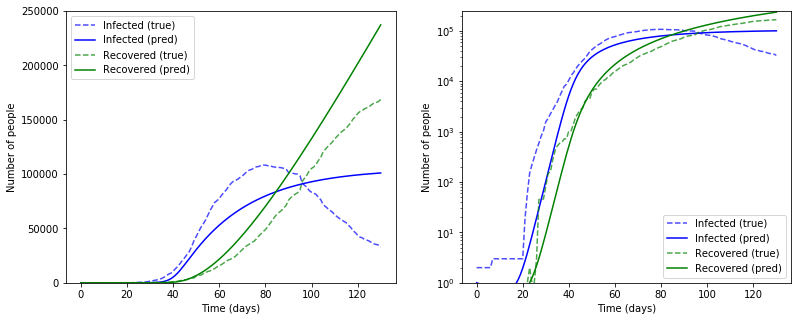

In [36]:
plot_data_together(time_points, solution_to_IRD(best_solution), true_ird, 250000, 
                   labels=["Infected", "Recovered"])